In [1]:
import numpy as np
from random import choices
from recogym.agents import Agent

# Define an Agent class.
class BanditAgentA(Agent):
    def __init__(self, config):
        # Set number of products as an attribute of the Agent.
        super(BanditAgentA, self).__init__(config)

        self.product_weights = np.ones(self.config.num_products)
        self.factor_reward = 1.99
        self.factor_punish = 1.01


    def train(self, observation, action, reward, done):
        """Train method learns from a tuple of data.
            this method can be called for offline or online learning"""

        # Reward good bandits, punish bad ones
        # This is identical to: 
        # 1 * 1.99**clicks * 1.01**-(views - clicks)
        if reward:
            if reward == 1:
                # Reward clicks
                self.product_weights[action['a']] *= self.factor_reward
            else:
                # Punish views without click
                self.product_weights[action['a']] /= self.factor_punish

            
    def act(self, observation, reward, done):
        """Act method returns an action based on current observation and past
            history"""

        # Choosing action randomly in proportion to bandit feedback
        action = choices(range(self.config.num_products), weights=self.product_weights, k=1).pop()

        return {
            **super().act(observation, reward, done),
            **{
                'a': action,
                'ps': self.product_weights[action] / sum(self.product_weights),
                'ps-a': self.product_weights / sum(self.product_weights)
            }
        }

In [2]:
class BanditAgentRecFreq(Agent):
    def __init__(self, config):
        # Set number of products as an attribute of the Agent.
        super(BanditAgentRecFreq, self).__init__(config)

        self.product_weights = np.ones(self.config.num_products)
        self.recommend_freq = np.zeros((self.config.num_products, 2))
        self.factor_reward = 1.99
        self.factor_punish = 1.01

    def train(self, observation, action, reward, done):
        """Train method learns from a tuple of data.
            this method can be called for offline or online learning"""
        if action:
            self.recommend_freq[action["a"]][0] += 1
            
        # Reward good bandits, punish bad ones
        if reward:
            if reward == 1:
                self.product_weights[action["a"]] *= self.factor_reward
                self.recommend_freq[action["a"]][1] += 1
            else:
                self.product_weights[action["a"]] /= self.factor_punish

            
    def act(self, observation, reward, done):
        """Act method returns an action based on current observation and past
            history"""

        # Choosing action randomly in proportion to bandit feedback
        action = choices(range(self.config.num_products), weights=self.product_weights, k=1).pop()
        
        recommend_freq_med = np.median(self.recommend_freq, axis=0)[0] #Threshold for number of recommendations
        num_click_med = np.median(self.recommend_freq, axis=0)[1] #Threshold for number of clicks
        
        if self.recommend_freq[action][0] > recommend_freq_med and self.recommend_freq[action][1] < num_click_med:
            self.product_weights[action] = 0.5
            action = choices(range(self.config.num_products), weights=self.product_weights, k=1).pop()
        
        return {
            **super().act(observation, reward, done),
            **{
                'a': action,
                'ps': self.product_weights[action] / sum(self.product_weights),
                'ps-a': self.product_weights / sum(self.product_weights)
            }
        }

In [3]:
import gym, recogym
from recogym import env_1_args, Configuration
from copy import deepcopy
from recogym.evaluate_agent import verify_agents, plot_verify_agents
from recogym.agents import RandomAgent, random_args


env_1_args['random_seed'] = 42
num_products = env_1_args['num_products']

env = gym.make('reco-gym-v1')
env.init_gym(env_1_args)

In [4]:
bandit_agent = BanditAgentA(Configuration(env_1_args))
bandit_agent_history = BanditAgentRecFreq(Configuration(env_1_args))
random_agent = RandomAgent(Configuration({
    **env_1_args,
    **random_args,
}))

num_offline_users = 1000
num_online_users = 1000
print(f'Training with {num_offline_users} users')
for useri in range(num_offline_users):

    # Reset env and set done to False.
    env.reset()
    done = False

    observation, reward, done = None, 0, False
    while not done:
        old_observation = observation
        action, observation, reward, done, info = env.step_offline(observation, reward, done)
        bandit_agent.train(old_observation, action, reward, done)
        bandit_agent_history.train(old_observation, action, reward, done)

Training with 1000 users


In [5]:
result = verify_agents(env,
                       num_online_users,
                       {
                           'Bandit Agent': bandit_agent,
                           'Random Agent': random_agent,
                           'Bandit Agent with History': bandit_agent_history
                       })
print(result)

                       Agent     0.025     0.500     0.975
0               Bandit Agent  0.013898  0.014732  0.015598
1               Random Agent  0.011186  0.011931  0.012708
2  Bandit Agent with History  0.013898  0.014732  0.015598
<class 'pandas.core.frame.DataFrame'>


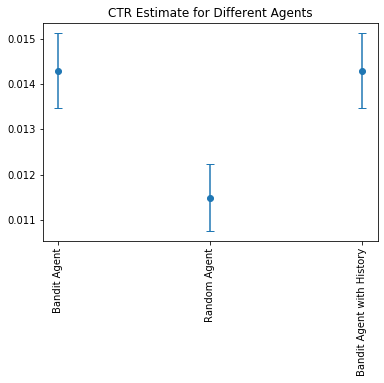

In [19]:
import matplotlib.pyplot as plt
fig = plot_verify_agents(result)
plt.show()